In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import time 
from pyDOE import lhs
from datetime import datetime
from IPython import display
import matplotlib.pyplot as plt

In [2]:
# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
    pass

In [3]:
class Struct(dummy):
    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)

In [4]:
OMEGA = 1
THETA_0 = 1

In [5]:
# Data size on the solution u
N_u = 1000
# Collocation points size, where we’ll check for f = 0
N_f = 10000


# DeepNN topology (1-sized input [t], 8 hidden layer of 20-width, 1-sized output [u]
list_of_layers = []
# [1, 80x8, 1]
max_node = 80  # List size
num_list = 1  # number of layer list
num_hidden = 3  # number of hidden layers
interval = max_node/num_list

for i in range(num_list):
    temp_list = [1]
    # Number of hidden layers
    for j in range(num_hidden):
        temp_list.append(max_node)
    temp_list.append(1)
    max_node -= interval
    list_of_layers.append(temp_list)

# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 5000
lr = 0.0001
beta1=0.9
eps = 0.1
noise = 0.01
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                        beta_1=beta1,
                                        epsilon=eps)

# # Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
# nt_epochs = 2000
# nt_config = Struct()
# nt_config.learningRate = 0.8
# nt_config.maxIter = nt_epochs
# nt_config.nCorrection = 50
# nt_config.tolFun = 1.0 * np.finfo(float).eps

In [6]:
def prep_data(N_u, N_f, noise=0.0):
    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([-1.0, 0.0] and [1.0, 1.0])
#     lb = 0
#     ub = num_pi *np.pi
#     # Generating the t points for f with a N_f size
#     # We pointwise add and multiply to spread the LHS over the domain
#     X_f = lb + (ub - lb) * lhs(1, N_f)
#     Exact_u = THETA_0*np.cos(OMEGA*X_f)
#     X_u_train = lb + (ub - lb) * lhs(1, N_f)
#     u_train = THETA_0*np.cos(OMEGA*X_u_train) + noise*np.random.randn(N_f, 1)
    
    npz = np.load("data/single_action_2_pendulum_data_L100.npz", allow_pickle=True)
    # Loading data and ordering it to N x 1 array
    states = npz["states"]
    theta = states[:,1]
    times = npz["time"][:,None]
    
#     # Trying something out with more dense x-axis
#     list_size = theta.shape[0]
#     steps = 0.01
#     times = [x*steps for x in range(list_size)]
#     times = np.array(times) 
#     times = times[:, None]
    
    # Adding noise
    mu, sigma = 0, noise
    # give same shape as data
    random_noise = np.random.normal(mu, sigma, [len(theta)])
    theta = theta + random_noise[:, None]
    
    
    
    # Reduce data set size for testing
    theta_train = theta[:N_u]
    time_train = times[:N_u]
    
    lb = times.min(axis=0)
    ub = times.max(axis=0)
#     time_train = lb + (ub - lb) * lhs(1, N_u)
    
    return times, theta, time_train, theta_train, lb, ub

In [7]:
class Logger(object):
    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() -
                                      self.start_time).strftime("%M:%S")

    def __get_error_u(self):
        return self.error_fn()
    
    def log_time(self):
        return time.time() - self.start_time
#         return datetime.fromtimestamp(time.time() -
#                                       self.start_time)
    
    def set_error_fn(self, error_fn):
        self.error_fn = error_fn

    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            print(
                f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  "
                + custom)

    def log_train_opt(self, name):
        # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        print(
            f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  "
            + custom)

In [8]:
# Time tracking functions
global_time_list = []
global_last_time = 0

In [9]:
def reset_time():
    global global_time_list, global_last_time
    global_time_list = []
    global_last_time = time.perf_counter()

In [10]:
def record_time():
    global global_last_time, global_time_list
    new_time = time.perf_counter()
    global_time_list.append(new_time - global_last_time)
    global_last_time = time.perf_counter()
    #print("step: %.2f"%(global_time_list[-1]*1000))

In [11]:
def last_time():
    """Returns last interval records in millis."""
    global global_last_time, global_time_list
    if global_time_list:
        return 1000 * global_time_list[-1]
    else:
        return 0

In [12]:
def dot(a, b):
    """Dot product function since TensorFlow doesn't have one."""
    return tf.reduce_sum(a * b)

In [13]:
def verbose_func(s):
    print(s)

In [14]:
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
        # Descriptive Keras model [2, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
#         self.u_model.add(tf.keras.layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:]:
            self.u_model.add(tf.keras.layers.Dense(
              width, activation=tf.nn.tanh,
              kernel_initializer='glorot_normal'))

#         self.u_model.add(
#             tf.keras.layers.Dense(1, activation="linear")
#         )
        
        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.nu = nu
        self.optimizer = optimizer
        self.logger = logger

        self.dtype = tf.float32

        # Separating the collocation coordinates
        self.t_f = tf.convert_to_tensor(X_f, dtype=self.dtype)

    # Defining custom loss
    def __loss(self, u, u_pred):
        f_pred = self.f_model()
        return tf.reduce_sum(tf.square(u - u_pred)) # + tf.reduce_sum(tf.square(f_pred))

    def __grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(u, self.u_model(X))
        return loss_value, tape.gradient(loss_value, self.u_model.trainable_variables)

    # The actual PINN
    def f_model(self):
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the input we’ll need later, t
            tape.watch(self.t_f)
            # Getting the prediction
            u = self.u_model(self.t_f)
            # Deriving INSIDE the tape (since we’ll need the t derivative of this later, u_tt)
            u_t = tape.gradient(u, self.t_f)

        # Getting the other derivatives
        u_tt = tape.gradient(u_t, self.t_f)
        
        del tape
        
        # Buidling the PINNs
        return u_tt + 10.*np.sin(u)

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    # The training function
    def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)
        self.logger.log_train_opt("Adam")
        for epoch in range(tf_epochs):
            # Optimization step
            loss_value, grads = self.__grad(X_u, u)
#             print(loss_value)
            self.optimizer.apply_gradients(zip(grads, self.u_model.trainable_variables))
            self.logger.log_train_epoch(epoch, loss_value)
            if epoch == tf_epochs - 1:
                final_loss.append(loss_value.numpy())
            if epoch % 14 == 0:
                plt.clf()
                plt.scatter(X_u, u, marker='.')
                plt.scatter(X_u, self.u_model(X_u), marker='.')
                display.display(plt.gcf())
                display.clear_output(wait=True)
                plt.savefig(f'./data/gif/{epoch}.jpg', dpi=300)
#                 plt.show()


        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.__loss(u, self.u_model(X_u))
            grad = tape.gradient(loss_value, self.u_model.trainable_variables)
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat =  tf.concat(grad_flat, 0)
            return loss_value, grad_flat


        self.logger.log_train_end(tf_epochs)

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.f_model()
        return u_star, f_star

In [15]:
"""## Training and plotting the results"""

'## Training and plotting the results'

In [16]:
# # Creating the model and training
# logger = Logger(frequency=10)
# # x, t, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise=0.0)
# X_f, Exact_u, X_u_train, u_train, lb, ub = prep_data(N_u, N_f, noise=noise)
# # plt.plot(Exact_u, ".")
# print(X_u_train.shape, u_train.shape)
# plt.scatter(X_u_train, u_train, marker='.')
# plt.show()

Training finished (epoch 5000): duration = 04:54  error = 1.5014e+00  
TensorFlow version: 2.1.0
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 80)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 81        
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
None
—— Starting Adam optimization ——

If you intended to run this layer in float32, you

KeyboardInterrupt: 

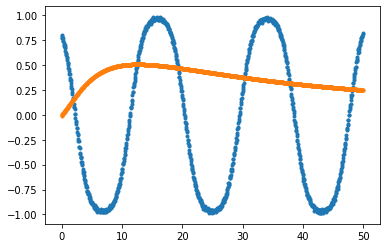

In [17]:
final_loss = []

# list of average loss for each layer
layer_avg_loss = []
layer_avg_time = []

n_times = 3
for layers in list_of_layers:
    final_loss = []
    average_time = []
    for i in range(n_times):
        # Creating the model and training
        logger = Logger(frequency=10)
        # x, t, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise=0.0)
        X_f, Exact_u, X_u_train, u_train, lb, ub = prep_data(N_u, N_f, noise=noise)

        pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_u_train, ub, lb, nu=OMEGA**2)
        def error():
            u_pred, _ = pinn.predict(X_f)
            return np.linalg.norm(Exact_u - u_pred, 2) / np.linalg.norm(Exact_u, 2)
        logger.set_error_fn(error)
        pinn.fit(X_u_train, u_train, tf_epochs)
        final_time = round(logger.log_time(), 3)
        average_time.append(final_time)

        # Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
        u_pred, f_pred = pinn.predict(X_f)
        plt.figure(figsize=(10,7))
        plt.scatter(X_u_train, u_train, label="input", marker='.')
        plt.scatter(X_f[:N_u], u_pred[:N_u], label="predicted", marker='.')
        plt.title(f"Data vs Predicted")
        plt.legend(loc="upper right")
        
        plt.savefig(f"./data/layers{layers}_{N_u}DataPoints_loss{str(round(final_loss[-1],3))}_time{final_time}_epoch{tf_epochs}_lr{lr}_beta{beta1}_eps{eps}_noise{noise}.jpg", dpi=300)
        # plt.show()
        plt.cla()
        plt.clf()
        plt.close()
        

    layer_avg_loss.append(np.average(final_loss))
    layer_avg_time.append(np.average(average_time))
    
for i in range(len(list_of_layers)):
    print(f"For the {list_of_layers[i]} layer data: ")
    print(f"Average loss: {layer_avg_loss[i]}")
    print(f"Average time: {layer_avg_time[i]}")
    print(" ")

In [ ]:
# pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_u_train, ub, lb, nu=OMEGA**2)
# def error():
#     u_pred, _ = pinn.predict(X_f)
#     return np.linalg.norm(Exact_u - u_pred, 2) / np.linalg.norm(Exact_u, 2)
# logger.set_error_fn(error)
# pinn.fit(X_u_train, u_train, tf_epochs)

In [ ]:
# # Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
# u_pred, f_pred = pinn.predict(X_f)
# plt.scatter(X_u_train, u_train, label="input", marker='.')
# plt.scatter(X_f[:N_u], u_pred[:N_u], label="predicted", marker='.')
# plt.title("Data vs Predicted (4pi)")
# plt.legend(loc="upper right")
# plt.savefig(f"./data/layers{layers}")

# plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train,
#   Exact_u, X, T, x, t)